# Community detection algorithms using *networkx* and *igraph* python modules
The main goal of this notebook is to show the implementation of different community detection algorithms, applied to some provided networks, and to compare the obtained partitions and results. <br>
We'll use some community detection algorithms implemented in the [networkx](https://networkx.org/documentation/stable/index.html#) python package and others implemented in [igraph](https://igraph.org/python/) for python.<br>
All the plots will be realized by using *networkx*, in order to have similar plots among the various partitions of each network.

### Load libraries

In [1]:
# load libraries
import networkx as nx
import igraph as ig
import numpy as np
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from networkx.utils import open_file
from collections import defaultdict

plt.rcParams["figure.figsize"] = (12, 12)
nets_path = "nets"
seed = 123

In [2]:
# traverse all the network files
#for r, s, files in os.walk(nets_path):
#    for f in files:
#        if f.split(".")[-1] == "net": # To avoid .clu files 
#            print(f"------- Network: {r}\{f} -----")
#            g = nx.read_pajek(os.path.join(r, f))
#            print(f"{g.number_of_nodes()} nodes, {g.number_of_edges()} edges.")

## Testing on a single network

In [3]:
network_f = "real"
network_name = "zachary_unwh"

In [4]:
# read the network
path = os.path.join("nets", network_f, network_name + '.net')
G = nx.read_pajek(path)

### Some network descriptors

In [5]:
nnodes = G.number_of_nodes()
print("Number of nodes: {}".format(nnodes))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

#print("Clustering: {}".format(round(nx.average_clustering(G), 4))) <----->
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 34
Number of edges: 78
Min degree: 1
Max degree: 17
Avg degree: 4.5882
Assortativity: -0.4756
Avg path length: 2.4082
Diameter: 5


### Plot the net

For networks that already contain coordinates of the nodes, we use the same coordinates to perform the plotting of the network. We therefore define the following auxiliary function that reads the coordinates from the network pajek file and populates a dictionary containing the coordinate of each node.

In [6]:
@open_file(0, mode='rb')
def read_net_positions(path, encoding = 'UTF-8'):
    pos = {} # dictionary to be populated with the coordinates of each node
    
    lines = (line.decode(encoding) for line in path)

    if isinstance(lines, str):
        lines = iter(lines.split('\n'))
    lines = iter([line.rstrip('\n') for line in lines])
    
    while lines:
        try:
            l = next(lines)
        except: # EOF
            break
        if l.lower().startswith("*vertices"): # first line
            l, nnodes = l.split()
            for i in range(int(nnodes)):
                l = next(lines)
                splitted = l.split()
                splitted[2:4] = [float(el) for el in splitted[2:4]]
                pos[str(splitted[1])] = splitted[2:4]

    return pos  

For the networks without a provided node positioning, since we want to provide proper visualisation of the communities, we will use the layout algorithm proposed by Kamada-Kawai which renders the network with minimal edge-overlapping. <br>
Original paper: https://doi.org/10.1016/0020-0190(89)90102-6<br>

In [7]:
# compute nodes position
pos = read_net_positions(path) # read positions from network file

if len(tuple(pos.values())[0]) == 0:
    pos = nx.kamada_kawai_layout(G)

Note that the same nodes coordinates will be reused for all the plots of the partitions of the same network, in order to allow an easy visual inspection of the different created clusters

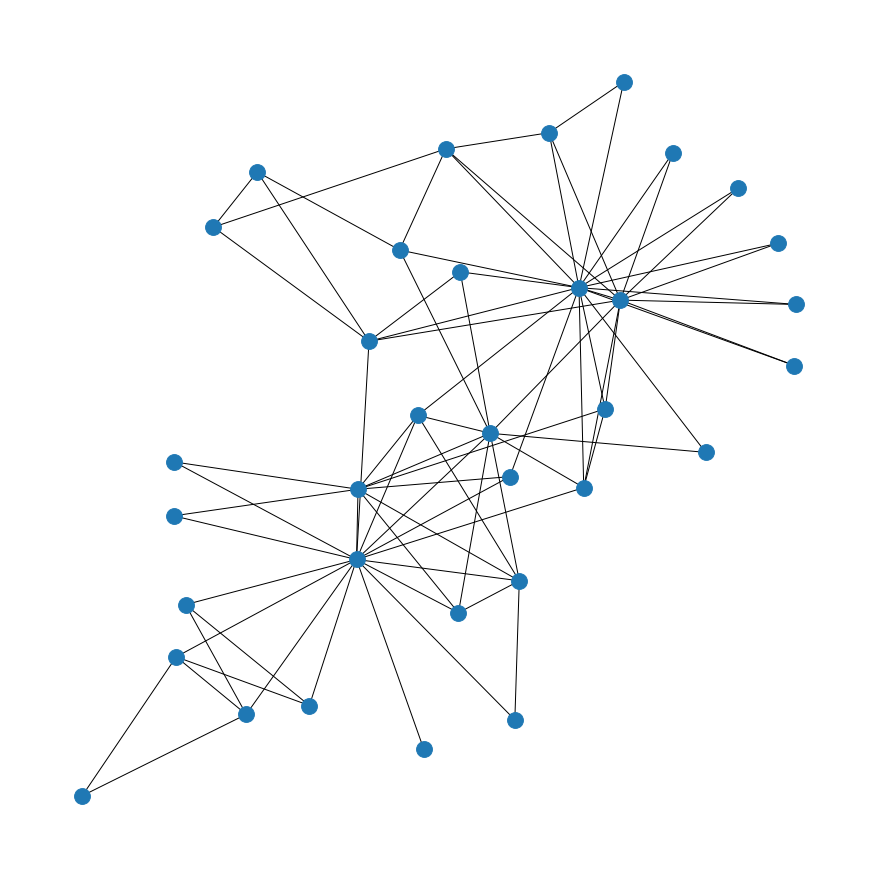

In [8]:
# perform the drawing, by using the node coordinates calculated above

# select node size depending on the network size
if nnodes >= 2000:
    node_size = 30
elif nnodes >= 1000 and nnodes < 2000:
    node_size = 50
elif nnodes >= 500 and nnodes  < 1000:
    node_size =  150
else:
    node_size = 250
    

nx.draw(G, pos=pos, node_size=node_size)

plt.savefig(os.path.join("images", network_f, network_name + '_intro-plot.png')) # to save the plot

With the plot of this network, we are able to identify several communities with our human vision, as we are naturally able to make complex associations between objects. However, for real-world usecases (and for complex networks), we need to implement algorithms that can compute communities, like we are doing, based on different criteria specific to each algorithm: betweeness, maximum modularity and so on.

## Greedy method of Newman: modularity maximization
Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity. <br>
Reference paper: [https://arxiv.org/abs/cond-mat/0408187](https://arxiv.org/abs/cond-mat/0408187).<br><br>
The algorithm finds communities by using a modularity maximization approach: it begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no futher increase in modularity is possible.
For the detailed implementation, see the [networkx](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities) reference. We apply the algorithm with the default parameters.

### Community detection

In [9]:
communities = nx_comm.greedy_modularity_communities(G, weight='weight')

print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 3


In [10]:
# first community (the largest)
#print(sorted(communities[0]))

### Modularity
Let's calculate the modularity of the graph with respect to the obtained partitioning of the vertices. <br>
It measures how strongly separated the different clusters are from each other compared to a random null model. <br>
*networkx* implementation: [https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity). <br>

We use the default *resolution* parameter set to 1.

In [11]:
nx_comm.modularity(G, communities)

0.3806706114398422

### Community visualisation
Let's plot the nodes with a different colour for each identified community

In [12]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for node in G.nodes():    
    for i in range(len(communities)):
        if node in sorted(communities[i]):
            if '*' in str(node):
                part[int(node.replace('*', ""))] = i
            else:
                part[node] = i
#print(part)

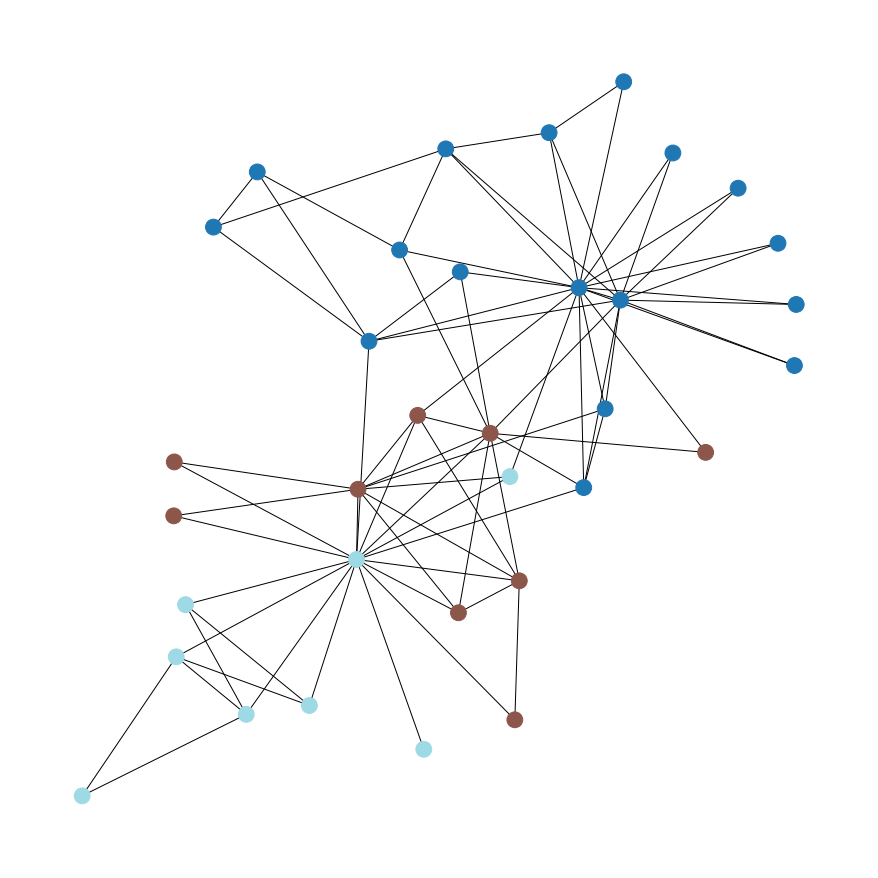

In [13]:
# get colormap to color nodes according to their partition
if len(communities) > 20:
    cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
    #cmap = cm.get_cmap('tab20', max(part.values()) + 1)
else:
    cmap = cm.get_cmap('tab20', max(part.values()) + 1)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=node_size)
plt.savefig(os.path.join("images", network_f, network_name + '_greedy.png'))
plt.show()

### Write partitions in Pajek format (.clu)
We define an auxiliary function to save the obtained partition as a .clu file

In [14]:
@open_file(1, mode='wb')
def write_pajek_communities(communities, path, encoding = 'UTF-8'):
    
    first_line = f"*Vertices {G.number_of_nodes()}"
    first_line += '\r\n'
    path.write(first_line.encode(encoding))
    
    for comm in part.values():
        line = f"{comm+1}"
        line += '\r\n'
        path.write(line.encode(encoding))        

In [15]:
# write pajek partition file
path = os.path.join('partitions', network_f, network_name + '_greedy.clu')
write_pajek_communities(part, path) # write file

## Asynchronous label propagation

The algorithm proceeds as follows: after initializing each node with a unique label, the algorithm repeatedly sets the label of a node to be the label that appears most frequently among that nodes neighbors. The algorithm halts when each node has the label that appears most frequently among its neighbors. The algorithm is asynchronous because each node is updated without waiting for updates on the remaining nodes.

The algorithm is implemented in the *networkx* package, and all the details can be seen [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.asyn_lpa_communities.html#networkx.algorithms.community.label_propagation.asyn_lpa_communities). <br>
Reference paper: [https://arxiv.org/abs/0709.2938).

### Community detection

In [16]:
communities = nx_comm.asyn_lpa_communities(G, weight='weight')

In [17]:
partitions = []
for i, elem in enumerate(communities):
    print("Partition {}".format(i))
    print(elem)
    partitions.append(list(elem))

Partition 0
{'31', '1', '3', '4', '22', '29', '13', '14', '20', '12', '18', '9', '2', '8'}
Partition 1
{'5', '11'}
Partition 2
{'6', '17', '7'}
Partition 3
{'27', '10', '24', '28', '30', '21', '34'}
Partition 4
{'23', '15', '16', '33', '19'}
Partition 5
{'32', '25', '26'}


In [18]:
print("Number of found communities: {}".format(i+1))

Number of found communities: 6


### Modularity

In [19]:
nx_comm.modularity(G, partitions)

0.3211702827087442

### Community visualization

In [20]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for node in G.nodes():    
    for i in range(len(partitions)):
        if node in sorted(partitions[i]):
            if '*' in str(node):
                part[int(node.replace('*', ""))] = i
            else:
                part[node] = i
#print(part)

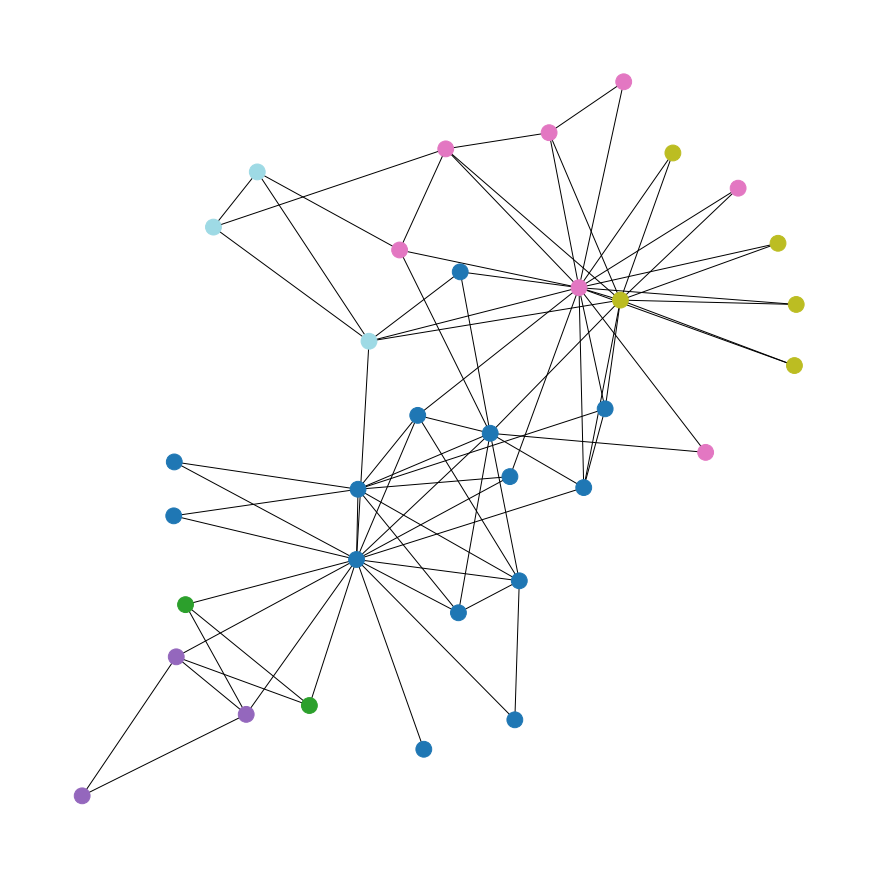

In [21]:
# draw nodes, with a different color for each community
# get colormap to color nodes according to their partition
if len(partitions) > 20:
    cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
    #cmap = cm.get_cmap('tab20', max(part.values()) + 1)
else:
    cmap = cm.get_cmap('tab20', max(part.values()) + 1)
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=node_size)

plt.savefig(os.path.join("images", network_f, network_name + '_asyn.png'))
plt.show()

In [22]:
# write pajek partition file
path = os.path.join('partitions', network_f, network_name + '_asyn.clu')
write_pajek_communities(part, path)

## Louvain Community Detection Algorithm

The algorithm is based on the optimization of the modularity measure and a hierarchical approach. Initially, each vertex is assigned to a community on its own. In every step, vertices are re-assigned to communities in a local, greedy way: in a random order, each vertex is moved to the community with which it achieves the highest contribution to modularity. When no vertices can be reassigned, each community is considered a vertex on its own, and the process starts again with the merged communities. The process stops when there is only a single vertex left or when the modularity cannot be increased any more in a step.

The algorithm is implemented in the *networkx* package, and all the details can be seen [here](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities). <br>
Reference paper: [https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008).

### Community detection

In [23]:
communities = nx_comm.louvain_communities(G, weight='weight', seed=seed)

In [24]:
print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 4


In [25]:
# first community
#print(sorted(communities[0]))

### Modularity

In [26]:
nx_comm.modularity(G, communities)

0.41978961209730437

### Community visualization

In [27]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for node in G.nodes():    
    for i in range(len(communities)):
        if node in sorted(communities[i]):
            if '*' in str(node):
                part[int(node.replace('*', ""))] = i
            else:
                part[node] = i
#print(part)

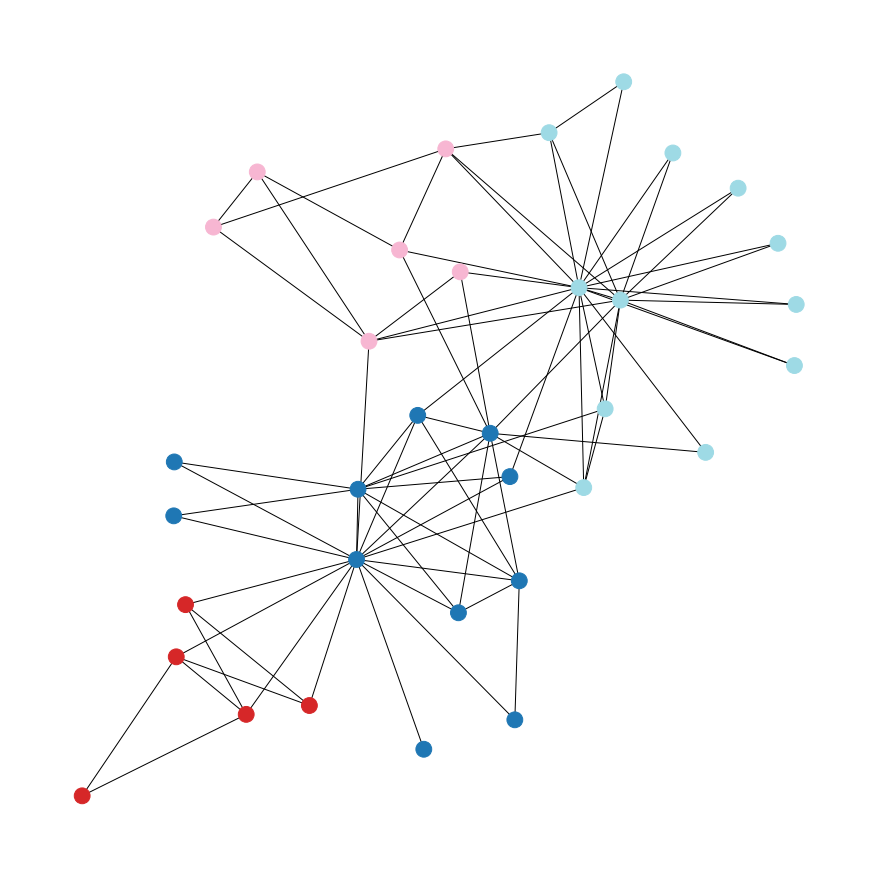

In [28]:
# get colormap to color nodes according to their partition
if len(communities) > 20:
    cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
    #cmap = cm.get_cmap('tab20', max(part.values()) + 1)
else:
    cmap = cm.get_cmap('tab20', max(part.values()) + 1)
    
# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=node_size)
plt.savefig(os.path.join("images", network_f, network_name + '_louvain.png'))
plt.show()

In [29]:
# write pajek partition file
path = os.path.join('partitions', network_f, network_name + '_louvain.clu')
write_pajek_communities(part, path)

## Spinglass community detection by Reichardt and Bornholdt 

This algorithm tries to find communities in graphs via a spin-glass model and simulated annealing.
The algorithm is implemented in the *igraph* package, and all the details can be seen [here](https://igraph.org/c/doc/igraph-Community.html#igraph_community_spinglass). <br>
Reference paper: [https://arxiv.org/abs/cond-mat/0603718).

In [30]:
# read the net as an igraph graph
g = ig.Graph.Read_Pajek(os.path.join("nets", network_f, network_name + '.net'))

In [31]:
# num.vertices, num.edges, attributes for vertices and edges
ig.summary(g)

IGRAPH UNW- 34 78 -- 
+ attr: id (v), name (v), x (v), y (v), z (v), weight (e)


### Community detection

In [32]:
communities = g.community_spinglass(weights=g.es["weight"])
#communities = g.community_spinglass()

print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 4


In [33]:
# first identified community
#communities.__getitem__(0)

### Modularity
*igraph* implementation of the modularity: [https://igraph.org/c/doc/igraph-Community.html#igraph_modularity](https://igraph.org/c/doc/igraph-Community.html#igraph_modularity). <br>
It is the same as the one of *networkx*

In [34]:
# in case of weighted networks, we compute the weighted modularity
mod = g.modularity(communities, weights = g.es["weight"])
mod

0.4197896120973045

### Community visualization

In [35]:
# community of each node of the net
#print(communities.membership)

In [36]:
nodes = list(G.nodes())

In [37]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for i in range(len(communities.membership)):
    part[nodes[i]] = communities.membership[i]

#print(part)

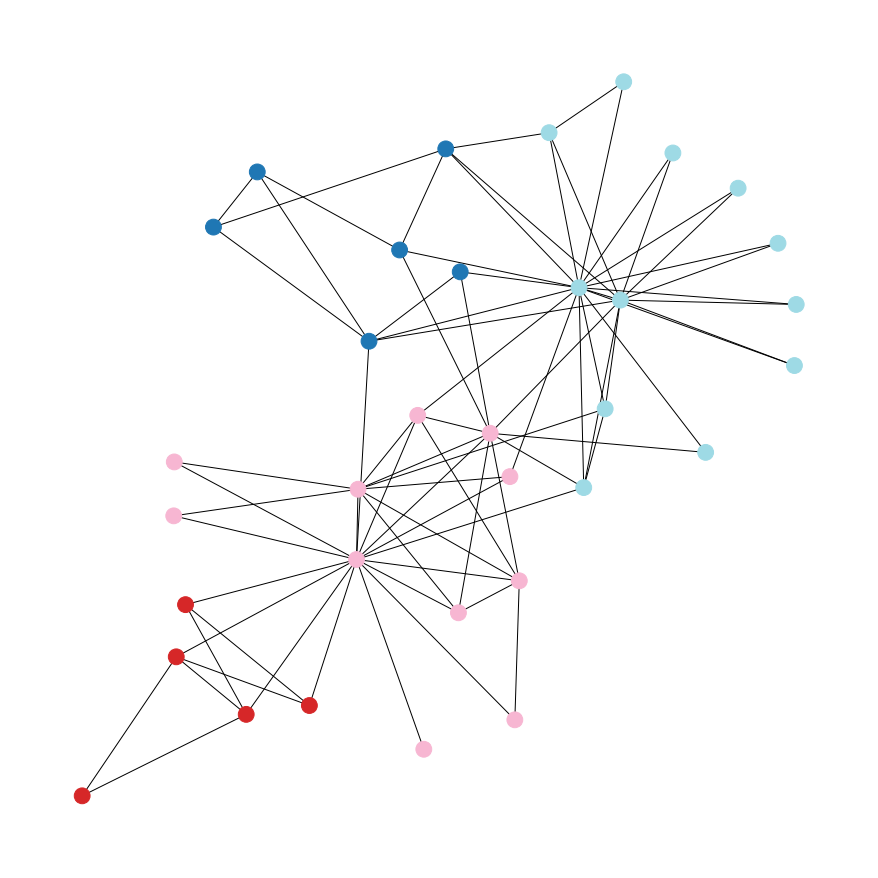

In [38]:
# get colormap to color nodes according to their partition
if len(communities) > 20:
    cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
    #cmap = cm.get_cmap('tab20', max(part.values()) + 1)
else:
    cmap = cm.get_cmap('tab20', max(part.values()) + 1)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=node_size)
plt.savefig(os.path.join("images", network_f, network_name + '_spinglass.png'))
plt.show()

In [39]:
# write pajek partition file
path = os.path.join('partitions', network_f, network_name + '_spinglass.clu')
write_pajek_communities(part, path)

## Walktrap community detection by Pons and Latapy
Community structure based on random walks

The algorithm basically tries to find densely connected subgraphs (communities) in a graph via random walks. The idea
is that short random walks tend to stay in the same community.
The algorithm is implemented in the *igraph* package, and all the details can be seen [here](https://igraph.org/c/doc/igraph-Community.html#igraph_community_walktrap). <br>
Reference paper: [https://arxiv.org/abs/physics/0512106](https://arxiv.org/abs/physics/0512106).

### Community detection

In [40]:
communities = g.community_walktrap(weights=g.es["weight"])

In [41]:
# in this case the output is a dendrogram, i.e. a hierarchy of partitions
communities

In [42]:
print(communities)

Dendrogram, 34 elements, 33 merges

19 0 7 3 1 21 17 12 11 10 4 6 5 16 13 2 9 30 8 31 28 33 32 15 14 18 20 22 29 26 27 23 25 24
|  | | | | |  |  |  |  |  | | | |  |  | | |  | |  |  |  |  |  |  |  |  |  |  |  |  |  |  |
|  | `-' | |  |  |  |  `--' `-' |  |  | | `--' |  |  `--'  |  |  |  |  |  `--'  |  |  `--'
|  |  |  | |  |  |  |   |    |  |  |  | |  |   |  |   |    |  |  |  |  |   |    |  |   |  
|  |  `--' |  |  |  |   |    |  |  `--' |  |   |  |   `----'  |  |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |    |  |   |   |  |   |  |     |     |  |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |    |  |   |   |  |   |  |     `-----'  |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |    |  |   |   |  |   |  |        |     |  |  |   |    |  |   |  
|  |   |   |  |  |  |   |    |  |   |   |  |   |  |        `-----'  |  |   |    |  |   |  
|  |   |   |  |  |  |   |    |  |   |   |  |   |  |           |     |  |   |    |  |   |  
|  |   |   |  |  |  |   |    |  |   |   |  |   |  |  

In [43]:
# Cut the dendogram in the max modularity level
communities = communities.as_clustering()
print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 5


In [44]:
#communities.__getitem__(0)

### Modularity

In [45]:
mod = g.modularity(communities, weights = g.es["weight"])
mod

0.3532215647600263

### Community visualization

In [46]:
# community of each node of the net
#print(communities.membership)

In [47]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for i in range(len(communities.membership)):
    part[nodes[i]] = communities.membership[i]

#print(part)

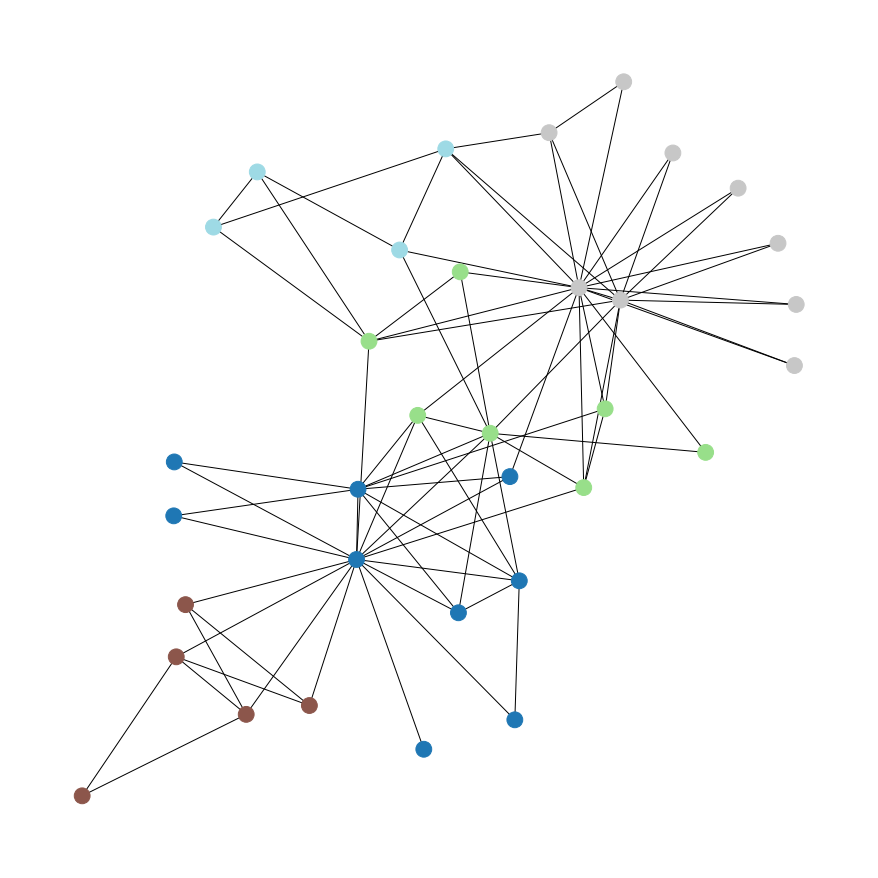

In [48]:
# get colormap to color nodes according to their partition
if len(communities) > 20:
    cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
    #cmap = cm.get_cmap('tab20', max(part.values()) + 1)
else:
    cmap = cm.get_cmap('tab20', max(part.values()) + 1)

# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=node_size)
plt.savefig(os.path.join("images", network_f, network_name + '_walktrap.png'))
plt.show()

In [49]:
# write pajek partition file
path = os.path.join('partitions', network_f, network_name + '_walktrap.clu')
write_pajek_communities(part, path)

## Girvan–Newman (GN)
The GN algorithm is one of the most famous community detection algorithm and also one of the most intuitive. The specificity of this algorithm is the use of **betweeness centrality** of an edge: the number of shortest path between nodes in which this edge is part of. <br>
The idea is that the betweenness of the edges connecting two communities is typically high, as many of the shortest paths between nodes in separate communities go through them. So we gradually remove the edge with highest betweenness from the network, and recalculate edge betweenness after every removal. This way sooner or later the network falls off to two components, then after a while one of these components falls off to two smaller components, etc. until all edges are removed. This is a divisive hierarchical approach, the result is a dendrogram. <br>
The algorithm is implemented in the *igraph* package, and all the details can be seen [here](https://igraph.org/c/doc/igraph-Community.html#igraph_community_edge_betweenness). <br>
Reference paper: [https://arxiv.org/abs/cond-mat/0112110](https://arxiv.org/abs/cond-mat/0112110).

### Community detection

In [50]:
communities = g.community_edge_betweenness()

In [51]:
# in this case the output is a dendrogram, i.e. a hierarchy of partitions
communities

In [52]:
print(communities)

Dendrogram, 34 elements, 33 merges

2 28 27 24 25 31 26 14 15 18 20 22 8 30 23 29 32 33 9 0 1 3 13 7 21 19 17 12 11 5 6 16 4 10
| |  |  |  |  |  |  |  |  |  |  |  | |  |  |  |  |  | | | | |  | |  |  |  |  |  | | |  | |
| |  |  |  |  |  |  |  |  |  |  |  | |  |  |  `--'  | | | | |  | |  |  |  |  |  | | |  | |
| |  |  |  |  |  |  |  |  |  |  |  | |  |  |   |    | | | | |  | |  |  |  |  |  | | |  | |
| |  |  |  `--'  |  |  |  |  |  |  | |  |  `---'    | | | | |  | |  |  |  |  |  | | |  | |
| |  |  |   |    |  |  |  |  |  |  | |  |    |      | | | | |  | |  |  |  |  |  | | |  | |
| |  |  `---'    |  |  |  |  |  |  | |  `----'      | | | | |  | |  |  |  |  |  | `-'  | |
| |  |    |      |  |  |  |  |  |  | |    |         | | | | |  | |  |  |  |  |  |  |   | |
`-'  |    |      |  |  |  |  |  |  | |    |         | | | `-'  | |  |  |  |  |  `--'   `-'
 |   |    |      |  |  |  |  |  |  | |    |         | | |  |   | |  |  |  |  |   |      | 
 |   |    |      |  |  |  |  |  |  | |    |         |

In [53]:
# Cut the dendogram in the max modularity level
communities = communities.as_clustering()
print("Number of found communities: {}".format(len(communities)))
#print("\nCommunities:")
#print(communities)

Number of found communities: 5


In [54]:
#communities.__getitem__(0)

### Modularity

In [55]:
mod = g.modularity(communities, weights = g.es["weight"])
mod

0.40129848783694944

### Community visualization

In [56]:
# community of each node of the net
#print(communities.membership)

In [57]:
# dict assigning to each node the corresponding community number: we need this to build a color map
part = {}

for i in range(len(communities.membership)):
    part[nodes[i]] = communities.membership[i]

#print(part)

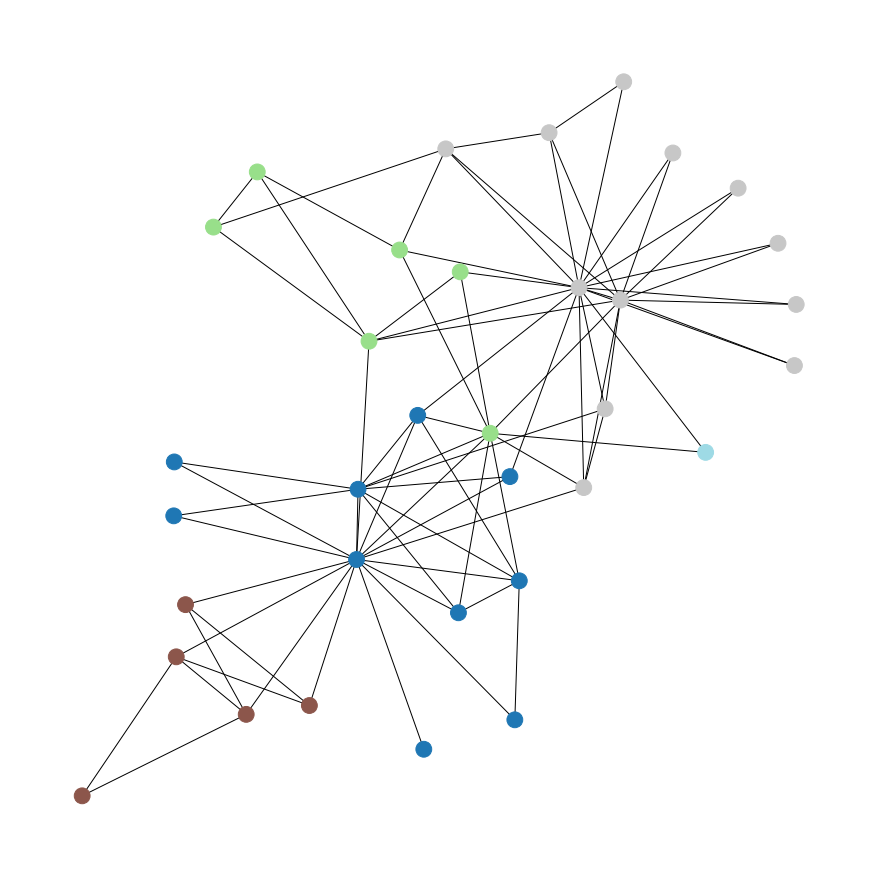

In [58]:
# get colormap to color nodes according to their partition
if len(communities) > 20:
    cmap = cm.get_cmap('gist_ncar', max(part.values()) + 1)
    #cmap = cm.get_cmap('tab20', max(part.values()) + 1)
else:
    cmap = cm.get_cmap('tab20', max(part.values()) + 1)
# draw nodes, with a different color for each community
nx.draw(G, pos=pos, cmap=cmap, node_color=list(part.values()), node_size=node_size)
plt.savefig(os.path.join("images", network_f, network_name + '_girvan-newman.png'))
plt.show()

In [59]:
# write pajek partition file
path = os.path.join('partitions', network_f, network_name + '_girvan-newman.clu')
write_pajek_communities(part, path)

### Compute modularities of the already provided partitions
We define now an auxiliary function for reading a *.clu* file (pajex partitions file). The function returns the list of communities.<br>
We' ll need it to compute the modularity of the already provided network partitions.

In [60]:
@open_file(0, mode='rb')
def read_pajek_communities(path, encoding='UTF-8'):
    lines = (line.decode(encoding) for line in path)
    
    if isinstance(lines, str):
        lines = iter(lines.split('\n'))
    lines = iter([line.rstrip('\n') for line in lines])
    
    while lines:
        try:
            l = next(lines)
        except:  # EOF
            break
        if l.lower().startswith("*vertices"):
            l, nnodes = l.split()
            communities = defaultdict(list)
            for vertex in range(int(nnodes)):
                l = next(lines)
                community = int(l)
                communities.setdefault(community, []).append(vertex)
        else:
            break
            
    return [ v for k,v in dict(communities).items() ]

In [61]:
network_f = "real"
network_part_name = "zachary_unwh-real"

# read the network
path = os.path.join("nets", network_f, network_part_name + '.clu')
communities_pajek = read_pajek_communities(path, encoding='UTF-8')
#communities_pajek

In [62]:
# assign correct labels to the nodes in each partition
nodes_list = np.array(list(G.nodes))

for community in communities_pajek:
    for i, v in enumerate(community):
        community[i] = nodes_list[v]

### Compute modularity

In [63]:
nx_comm.modularity(G, communities_pajek)

0.37146614069691